**This example is used to demostrate the tool**

In [1]:
#Import our modules
import Service
import GlOb
import Comm 
import exeAreas
import exeMgn

#import modules for API
from API import srcAPI as src
from API import sinkAPI as sink
from API import FMUAPI
from API import MatlabAPI
from API import PythonAPI
#import necessary services such as Server to connect remote components
from API.comm_protos.TCP import TCPServer as Server

#import general modules from python
import time
import os

In [2]:
#import libraries from  models that are created in Pyton
#Models made in python
from Models import SpringProp

#import dataProcess unit also made in python.. with the rules stated in the code
from Models.dataProcess import CurrentSens

In [3]:
#Create all  interfaces

directory = os.getcwd() + '\\' + 'Models'

############## sensor inteface ###########################################
sens = src.Sensor(name  = 'current_sensor', config = {"type" : "freq", 'unit': 's', 'occurrences_per_unit':20},
                    sending_port = 55000, receiving_ports = [55001], 
                    outputsNames = ['current'])
sensName = 'current_sensor'
sens.save_to_csv(file_name=sensName)

############### Sink interface ##################################################
monitor = sink.Sink (comm_proto = 'TCP-IP', 
                    name  = 'coil_monitor', config = {"type" : "freq", "unit": "s", "occurrences_per_unit":20},
                    instruction_port = 60000, sending_ports=[60001, 60002,60003], 
                    inputsNames = ['position', 'mass','T_coil'])
sinkName =  "coil_monitor"
monitor.save_to_csv(file_name=sinkName)

################### Data Process unit interface

DatProcc = CurrentSens()
DataProc = PythonAPI.Wrapping(model = DatProcc,directory=directory,
                                 modelName = 'DPCurrentSens', typ = 'DataProc',
                                 inputsNames= ['rawData'], outputsNames= ['eCurrent'])
DP_name = 'DPCurrentSens'
DataProc.save_to_csv(file_name=DP_name)
######################################### Python model ########################################

#create python object from the model
SProperty_model = SpringProp.Model()

#Encapsulate the model to store its attributes 
inputsNames = ['R']
outputsNames = ['T_coil','k']
springProp_model = PythonAPI.Wrapping(model=SProperty_model, directory=directory,
                                      modelName='SpringProp',inputsNames=inputsNames, 
                                      outputsNames=outputsNames, exeSchedule={1:'execute'},
                                      printFlag=True)

SprinP_name = 'SpringProp'
springProp_model.save_to_csv(file_name=SprinP_name)
########################################### FMU Models #########################################
#not really needed for FMUs:

ElectricalHeat = FMUAPI.FMU(modelName='ElectricalHeat', directory=directory)

MassSpringKInput = FMUAPI.FMU(modelName='MassSpringKInput', directory=directory)

RiceCooker = FMUAPI.FMU(modelName='RiceCooker', directory=directory)

Data of the class has been extracted
For type DataProc the complete execution will be performed only by a method called: processData 
no parameters
Inputs and outputs have been defined for this model
Data of the class has been extracted
Inputs and outputs have been defined for this model
{'ports': ['R', 'T_coil', 'k', 'param'], 'methods': ['Tcoil_calculation', 'execute', 'k_calculation']}


In [9]:
#Component Manager

#instanciate all the components: by defining inputs, outputs and parameters 
# always as a dictionary {'name': , 'unit': , 'datatype'}


####################### #sensor component #########################################
output = {'name':"current", 'unit':'Amp', 'datatype':'JSON','val':''}
outputs = [output]

current_sens = Comm.Source(name = 'current_sensor',outputs = outputs)

################################ sink component #####################################
# 'position', 'mass','T_coil'
input1 = {'name':"position", 'unit':'m', 'datatype':'float','val':''}
input2 = {'name':"mass", 'unit':'kg', 'datatype':'float','val':''}
input3 = {'name':"T_coil", 'unit':'C', 'datatype':'float','val':''}
inputs = [input1,input2,input3]

coil_monitor =  Comm.Sink(name='coil_monitor',inputs=inputs)

######################## Data process component ####################################
directory = os.getcwd() + '\\' + 'Models'

input = {'name':"rawData", 'unit':'Amp', 'datatype':'JSON','val':''}
inputs = [input]
output = {'name':"eCurrent", 'unit':'Amp', 'datatype':'float','val':''}
outputs = [output]

dataprocess1 = Comm.Model(name='DPCurrentSens',SimE='Python',modelDir=directory, 
                          inputs=inputs,outputs=outputs, parameters=[])

######################### Python model: Spring Properties###########################
input1 = {'name':"R", 'unit':"ohms", 'datatype':"float",'val':''}

inputs = [input1]

output1 = {'name':"T_coil", 'unit':"C", 'datatype':"float",'val':''}
output2 ={'name':"k", 'unit':"N/m", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"R_25", 'unit':"ohms", 'datatype':"float",'val':'15'}
parameter2 = {'name':"alpha", 'unit':"-", 'datatype':"float",'val':'0.0039'}
parameter3 = {'name':"d_wire", 'unit':"mm", 'datatype':"float",'val':'0.127'}
parameter4 = {'name':"d_coil", 'unit':"mm", 'datatype':"float",'val':'1'}
parameter5 = {'name':"N", 'unit':"-", 'datatype':"float",'val':'9.25'}
parameters = [parameter1,parameter2,parameter3,parameter4,parameter5]

springProp = Comm.Model(name = 'SpringProp',SimE= "Python",modelDir = directory, 
                    inputs=inputs,outputs=outputs, parameters= parameters)

########################FMU model:##################################################
########################Electrical Heat#############################################
input1 = {'name':"I", 'unit':"Amps", 'datatype':"float",'val':''}
inputs = [input1]

output1 = {'name':"Q", 'unit':"Watts", 'datatype':"float",'val':''}
output2 = {'name':"R", 'unit':"Ohms", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"V", 'unit':"Vots", 'datatype':"float",'val':'150'}
parameters = [parameter1]

elecHeat = Comm.Model(name = 'ElectricalHeat', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)

########################  Cooker spring #############################################
input1 = {'name':"Force", 'unit':"N", 'datatype':"float",'val':''}
input2 = {'name':"k", 'unit':"N/m", 'datatype':"float",'val':''}
inputs = [input1,input2]

output1 = {'name':"DisplacementOutput", 'unit':"m", 'datatype':"float",'val':''}
outputs = [output1]

parameter1 = {'name':"dampingCoefficient", 'unit':"m", 'datatype':"float",'val':'-0.5'}
parameter2 = {'name':"mass", 'unit':"kg", 'datatype':"float",'val':'0.01'}
parameters = [parameter1,parameter2]

cookSpring = Comm.Model(name = 'MassSpringKInput', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)


######################## Rice cooker  #############################################
input1 = {'name':"Q", 'unit':"Watts", 'datatype':"float",'val':''}
inputs = [input1]

output1 = {'name':"mass_rice", 'unit':"kg", 'datatype':"float",'val':''}
output2 = {'name':"T_rice", 'unit':"kg", 'datatype':"float",'val':''}
outputs = [output1,output2]

parameter1 = {'name':"T_0", 'unit':"C", 'datatype':"float",'val':'18'}
parameter2 = {'name':"m_0", 'unit':"kg", 'datatype':"float",'val':'1.5'}
parameters = [parameter1,parameter2]

riceCooker = Comm.Model(name = 'RiceCooker', SimE = 'FMU', modelDir=directory,
                    inputs=inputs, outputs=outputs, parameters=parameters)

######################## Rice cooker configuration  #############################################

input1 = {'name':"T_0", 'unit':"C", 'datatype':"float",'val':'18'}
input2 = {'name':"m_0", 'unit':"kg", 'datatype':"float",'val':'1.5'}
inputs = [input1,input2]

confRiceCooker = Comm.ConfigComp(name = 'confRiceCooker', modelDir = directory, SimE = 'FMU',
                                 inputs=inputs, outputs= None, ModelObj=riceCooker)

The variables defined are connsistent with the sensor component current_sensor
The variables defined are connsistent with the sink component coil_monitor
Data of the class has been extracted
For type DataProc the complete execution will be performed only by a method called: processData 
no parameters
Inputs and outputs have been defined for this model
Data of the class has been extracted
Inputs and outputs have been defined for this model


In [10]:
# In this section I also define connection components if needed. 

# A duplicator for the mass output is needed, also transformator in after that duplication

##################### duplicator#####################
input ={'name':'mass','unit' : 'kg', 'datatype':'float','val':0}
dup1 = Comm.Duplicator(input=input,num_outputs=3)

########################### Transformator #############################
outputs= [{'name': 'Force', 'unit' : 'N', 'datatype':'float','val':'10'}]
inputs =[{'name':'mass','unit' : 'kg', 'datatype':'float','val':'100'}]
exp = 'Force = -9.8*mass'
vars = {'mass':1.5}

transform = Comm.Transformation(outputs=outputs, inputs=inputs, 
                            expressions=exp, variables=vars)


For duplicator duplicator497, the names of the outputs are:
mass0
mass1
mass2
 For transformator Transformator358, all outputs define in the equations are correct
For transformator Transformator358, all variables within the equations are correctly defined


In [11]:
#Communication manager

#define all the connections. 
# First I define each input and output. 

###################### Connection definition #####################################
# first define the connection handler
# sensor and monitor current_sens ('current'), coil_monitor ( 'position', 'mass','T_coil')
# data process unit dataprocess1 (rawData /  eCurrent)
# models:
# springProp (R/ T_coil, k) elecHeat (I/Q)  
# cookSpring (Force, k/DisplacementOutput) riceCooker (Q/mass_rice,T_rice)

# conector components dup1(mass/mass0,mass1,mass2)  transform(mass/Force)



###### Output Sensor###############
sensSrc1 = {'component': current_sens, 'output': 'current'}
####### Input monitor###############
sinkDst1 = {'component': coil_monitor, 'input': 'position'}
sinkDst2 = {'component': coil_monitor, 'input': 'mass'}
sinkDst3 = {'component': coil_monitor, 'input': 'T_coil'}
####### Input/output data processor unit###############
DPUSrc1 = {'component': dataprocess1, 'output': 'eCurrent'}
DPUDst1 = {'component': dataprocess1, 'input': 'rawData'}
####### Input/output springProp###############
SprPSrc1 = {'component': springProp, 'output': 'k'}
SprPSrc2 = {'component': springProp, 'output': 'T_coil'}
SprPDst1 = {'component': springProp, 'input': 'R'}
####### Input/output elecHeat###############
elecHeatSrc1 = {'component': elecHeat, 'output': 'Q'}
elecHeatSrc2 = {'component': elecHeat, 'output': 'R'}
elecHeatDst1 = {'component': elecHeat, 'input': 'I'}
####### Input/output cookSpring###############
cookSprDst1 = {'component': cookSpring, 'input': 'Force'}
cookSprDst2 = {'component': cookSpring, 'input': 'k'}
cookSprSrc1 = {'component': cookSpring, 'output': 'DisplacementOutput'}
####### Input/output riceCooker###############
RiceCookSrc1 = {'component': riceCooker, 'output': 'mass_rice'}
RiceCookSrc2 = {'component': riceCooker, 'output': 'T_rice'} #missing to confRiceCook
RiceCookDst1 = {'component': riceCooker, 'input': 'Q'}
####### Input/output confRiceCooker###############
ConfRiceCookDst1 = {'component': confRiceCooker, 'input': 'm_0'}
ConfRiceCookDst2 = {'component': confRiceCooker, 'input': 'T_0'} 

####### Input/output dup1###############

DupSrc3 = {'component': dup1, 'output': 'mass2'} #-> to confRiceCook
DupSrc2 = {'component': dup1, 'output': 'mass1'}
DupSrc1 = {'component': dup1, 'output': 'mass0'}
DupDst1 = {'component': dup1, 'input': 'mass'}

####### Input/output transform###############
TransfSrc1 = {'component': transform, 'output': 'Force'}
TransfDst1 = {'component': transform, 'input': 'mass'}

connections = exeMgn.ConnectionHandler()
#types of exchange patters used here:

fifo = {'type': 'FIFO'}
LVoC = {'type': 'LVoC'}
LVQ = {'type': 'LVQ'}

# connections
connections.connect(source=sensSrc1,destination=DPUDst1,exPattern=fifo)

connections.connect(source=DPUSrc1,destination=elecHeatDst1,exPattern=LVQ)

connections.connect(source=elecHeatSrc1,destination=RiceCookDst1,exPattern=fifo)
connections.connect(source=elecHeatSrc2,destination=SprPDst1,exPattern=fifo)

connections.connect(source=RiceCookSrc1,destination=DupDst1,exPattern=fifo)
connections.connect(source=RiceCookSrc2,destination=ConfRiceCookDst2,exPattern=LVoC)

connections.connect(source=DupSrc1,destination=sinkDst2,exPattern=LVoC)
connections.connect(source=DupSrc2,destination=TransfDst1,exPattern=fifo)
connections.connect(source=DupSrc3,destination=ConfRiceCookDst1,exPattern=LVoC)

connections.connect(source=TransfSrc1,destination=cookSprDst1,exPattern=fifo)

connections.connect(source=SprPSrc1,destination=cookSprDst2,exPattern=fifo)
connections.connect(source=SprPSrc2,destination=sinkDst3,exPattern=LVoC)

connections.connect(source=cookSprSrc1,destination=sinkDst1,exPattern=LVoC)

# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
# connections.connect(source=sensSrc1,destination=DPUDst1)
print(connections)


Connections are:
id:Conn0 ('current_sensor', 'current')->('DPCurrentSens', 'rawData')
id:Conn1 ('DPCurrentSens', 'eCurrent')->('ElectricalHeat', 'I')
id:Conn2 ('ElectricalHeat', 'Q')->('RiceCooker', 'Q')
id:Conn3 ('ElectricalHeat', 'R')->('SpringProp', 'R')
id:Conn4 ('RiceCooker', 'mass_rice')->('duplicator497', 'mass')
id:Conn5 ('RiceCooker', 'T_rice')->('confRiceCooker', 'T_0')
id:Conn6 ('duplicator497', 'mass0')->('coil_monitor', 'mass')
id:Conn7 ('duplicator497', 'mass1')->('Transformator358', 'mass')
id:Conn8 ('duplicator497', 'mass2')->('confRiceCooker', 'm_0')
id:Conn9 ('Transformator358', 'Force')->('MassSpringKInput', 'Force')
id:Conn10 ('SpringProp', 'k')->('MassSpringKInput', 'k')
id:Conn11 ('SpringProp', 'T_coil')->('coil_monitor', 'T_coil')
id:Conn12 ('MassSpringKInput', 'DisplacementOutput')->('coil_monitor', 'position')



Defult triggers will be used, no triggers as input
Correct guard definition for trigger StoptriggerSrcArea594


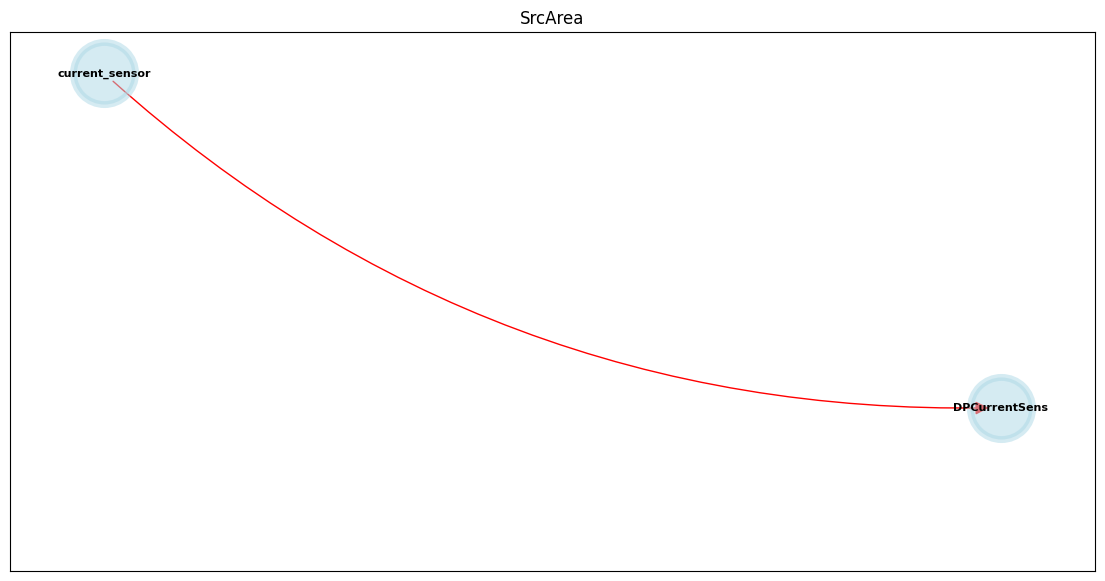

Correct guard definition for trigger StoptriggerCosimArea419


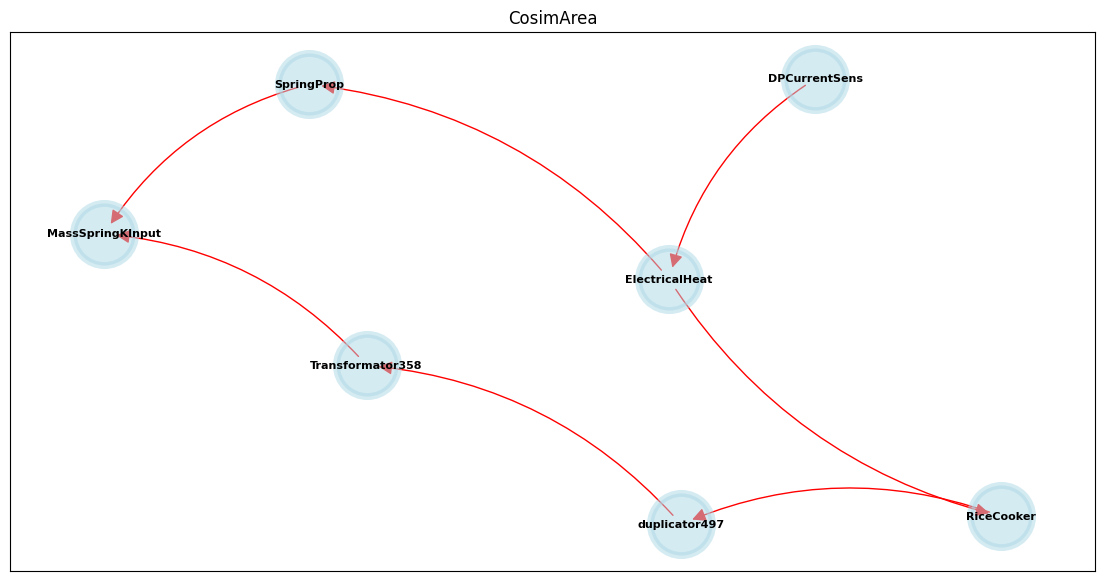

Correct guard definition for trigger StoptriggerConfigArea368


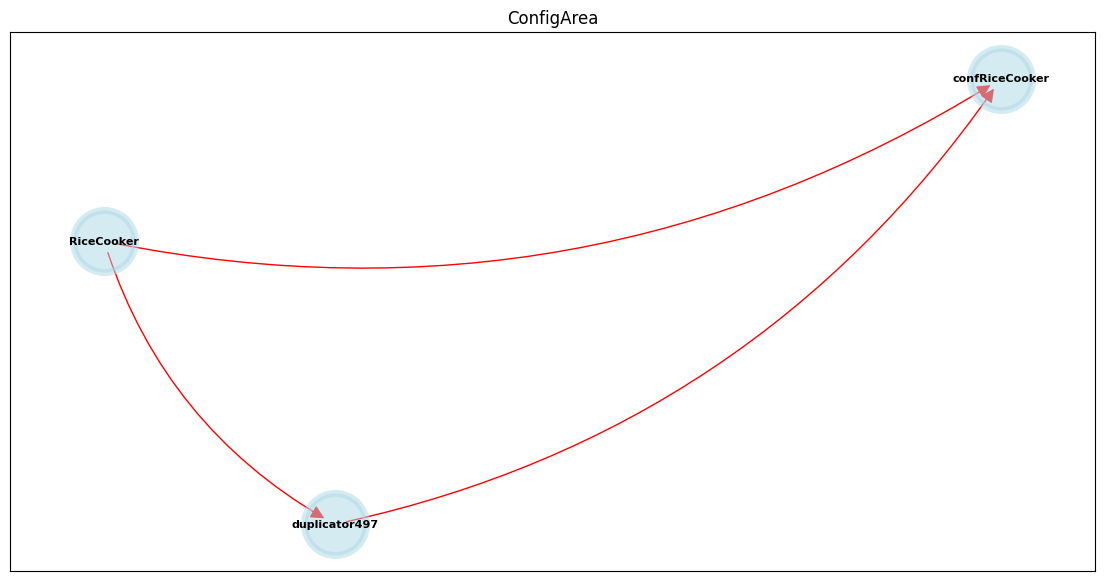

The continuos exection will execute based on the frequence of the inputs arriving to the models

Correct guard definition for trigger StoptriggerSinkArea985


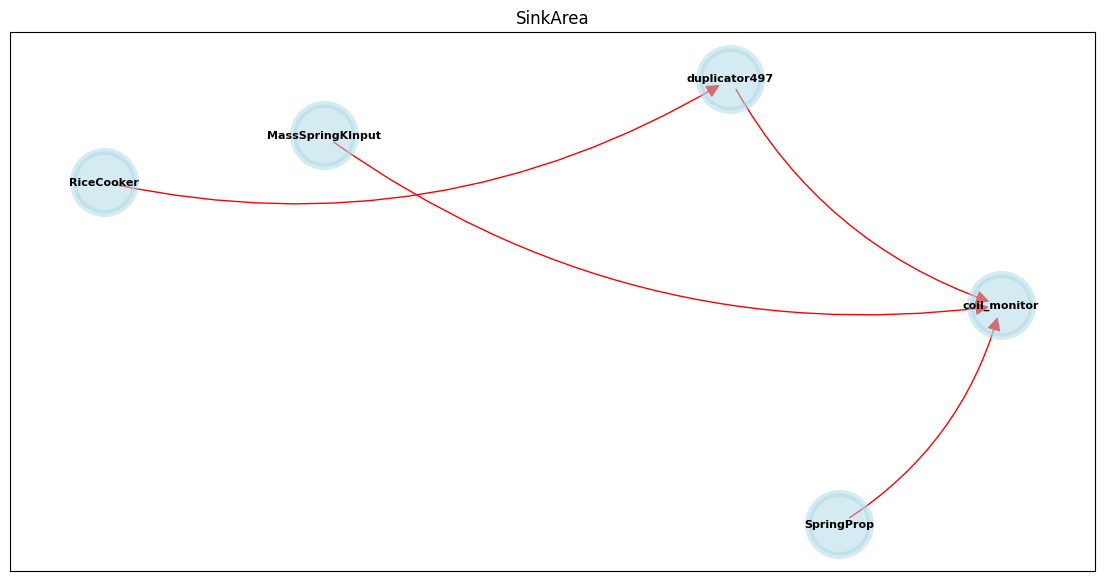

In [12]:
# Execution  manager
#generate and define all areas of execution

AppTime = GlOb.AppTime()
globals = GlOb.GlobalVars()

# sensor and monitor current_sens ('current'), coil_monitor ( 'position', 'mass','T_coil')
# data process unit dataprocess1 (rawData /  eCurrent)
# models:
# springProp (R/ T_coil, k) elecHeat (I/Q)  
# cookSpring (Force, k/DisplacementOutput) riceCooker (Q/mass_rice,T_rice)

# conector components dup1(mass/mass0,mass1)  transform(mass/Force)

#all componnets must be defined to feed the areas
allComponents = [globals,current_sens,coil_monitor,dataprocess1,
                 springProp,elecHeat,cookSpring,riceCooker,
                 dup1,transform, confRiceCooker]

areaSource = exeMgn.srcExe(name = 'SrcArea',components=[current_sens,dataprocess1],
                             exec_type='time_specific', triggers=[],
                             delayTime=2,allComponents=allComponents,appTime=AppTime)

# startTrigger = {'type':'start', 'class':'data','definition':'ElectricalHeat.I'}
startTrigger = {'type':'start', 'class':'temporal','definition':{'type':'freq','value': 10,'unit':'s'}}
triggers = [startTrigger]
config = {'exeTime':'FTRT','exeConf':{'t_ini':(0,'s'),'t_period':(10,'s'), 't_step':(1,'s')}}
areaCosim =  exeMgn.cosim(name='CosimArea', components=[elecHeat,springProp,riceCooker,cookSpring,transform,dup1],
                            simexec_type='time_based',triggers=triggers,configuration=config,
                            allComponents=allComponents,appTime=AppTime)


# startTrigger = {'type':'start', 'class':'data','definition':'confRiceCooker.m_0'}
startTrigger = {'type':'start', 'class':'temporal','definition':{'type':'freq','value': 10,'unit':'s'}}
triggers = [startTrigger]
areaConfig = exeMgn.cosim(name = 'ConfigArea', components=[confRiceCooker],
                          simexec_type='invoke',triggers=triggers,
                          allComponents=allComponents,appTime=AppTime)

# startTrigger = {'type':'start', 'class':'data','definition':'coil_monitor.position'}
startTrigger = {'type':'start', 'class':'temporal','definition':{'type':'freq','value': 11,'unit':'s'}}
triggers = [startTrigger]
areaSink = exeMgn.sinkExe(name = 'SinkArea', components=[coil_monitor],
                            exec_type='invoke',triggers=triggers,
                            delayTime=3, allComponents=allComponents,appTime=AppTime)

In [13]:
for comp in areaConfig.newExeComponents:
    print(comp.name)
print('----------------------------------------------------------')
for comp in areaCosim.newExeComponents:
    print(comp.name)
print('----------------------------------------------------------')
for comp in areaSink.exeComponents:
    print(comp.name)
print('----------------------------------------------------------')
for comp in areaSource.exeComponents:
    print(comp.name)
print('----------------------------------------------------------')

confRiceCooker
----------------------------------------------------------
ElectricalHeat
RiceCooker
duplicator497
Transformator358
SpringProp
MassSpringKInput
----------------------------------------------------------
coil_monitor
----------------------------------------------------------
current_sensor
DPCurrentSens
----------------------------------------------------------


In [20]:
area = areaCosim
print(area.innerAreaOutputs)
print(area.innerAreaInputs)
print(area.areaOutputs)
print(area.areaInputs)
for outport in area.allOutputs:
    print(outport.name)

{'ElectricalHeat': ['Q', 'R'], 'SpringProp': ['k'], 'RiceCooker': ['mass_rice'], 'Transformator358': ['Force'], 'duplicator497': ['mass1']}
{'SpringProp': ['R'], 'RiceCooker': ['Q'], 'MassSpringKInput': ['Force', 'k'], 'Transformator358': ['mass'], 'duplicator497': ['mass']}
{'SpringProp': ['T_coil'], 'RiceCooker': ['T_rice'], 'MassSpringKInput': ['DisplacementOutput'], 'duplicator497': ['mass0', 'mass2']}
{'ElectricalHeat': ['I']}
Q
R
mass_rice
T_rice
mass0
mass1
mass2
Force
T_coil
k
DisplacementOutput


In [15]:
areas = [areaSource,areaCosim,areaConfig,areaSink]
Ss = Service.MainManager(exeAreas=areas,globals=globals,appTime=AppTime)

In [ ]:
# Start server
ports = [55000,55001,60001,60002,60000,60003,60004]
server = Server(ports=ports)
server.start_server()

In [17]:
# Ss.startService()